In [1]:
import sys
import os

import pandas as pd
import numpy as np

# import libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)

#import libraries for features decomposition
import sklearn
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn import ensemble

# import mapper
import kmapper as km
from kmapper.plotlyviz import *

#Visualization param
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings("ignore")

In [31]:
df = pd.read_csv('../../data/nba/NBA_10_11.csv')
node_pos = df[['Player', 'PosicAbbrev']]
df3 = df[['PosicAbbrev', 'MIN', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PTS']].fillna(0)
df[['MIN', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PTS']] = df[['MIN', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PTS']].astype('float')
pos_dict = {' PG': 1, ' PF': 2, ' SG' : 3, ' SF' : 4, ' C' : 5}
invdict = {v: k for k, v in pos_dict.items()}

df = df[['Player', 'PosicAbbrev', 'AGE', 'GP', 'W', 'L', 'MIN', 'FGM',
       'FGA', 'FG%', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'DD2', 'TD3', 'PTS',
       '+/-', 'SALARY']]
df['PosicAbbrev'] = df['PosicAbbrev'].map(pos_dict)
feature_names = [c for c in df.columns if c not in ["Player", "PosicAbbrev"]]

X = np.array(df[feature_names].fillna(0))
y = np.array(df["PosicAbbrev"])

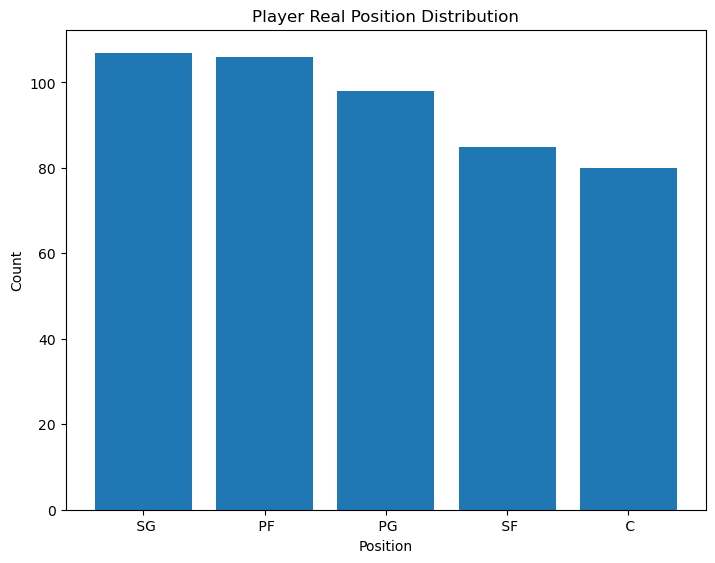

In [151]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
df2 = node_pos['PosicAbbrev'].value_counts().to_frame().reset_index()
ax.bar(df2['index'],df2['PosicAbbrev'])
plt.xlabel("Position")
plt.ylabel("Count")
plt.title("Player Real Position Distribution")
plt.show()

In [27]:
df3.isna().any().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of PosicAbbrev    False
MIN            False
REB            False
AST            False
TOV            False
STL            False
BLK            False
PTS            False
dtype: bool>

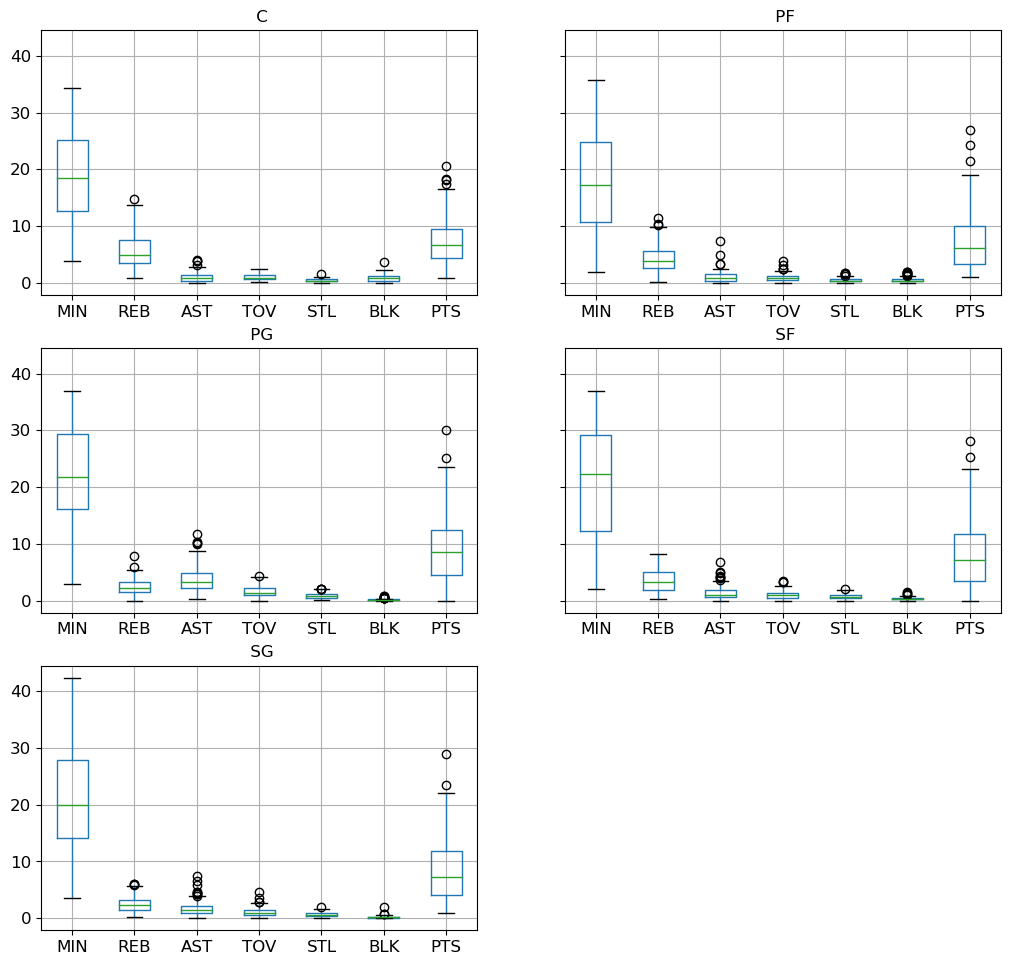

In [52]:
grouped = df3.groupby('PosicAbbrev')
plt = grouped.boxplot(rot=0, fontsize=12, figsize=(12,12), subplots=True, grid=True)

In [75]:
# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

# Define the simplicial complex
scomplex = mapper.map(lens,
                      X,
                      cover=km.Cover(n_cubes=12,
                                     perc_overlap=0.65),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))
pl_brewer = [[0.0, '#16537e'],
             [0.1, '#1a3298'],
             [0.2, '#6388bd'],
             [0.3, '#6a9dd9'],
             [0.4, '#8bb4ef'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]
color_values = lens[:,0] - lens[:,0].min()
my_colorscale = pl_brewer
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                 color_values,
                                                                 color_function_name='PPG',
                                                                 colorscale=my_colorscale)

for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological Network Representing NBA 2011 Season Player Positions',
                     width=1000, height=400,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)

fw_summary = summary_fig(mapper_summary, height=300)

dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, 
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)

fw_graph.data[1].marker.colorbar.title = 'PPG'
fw_graph.show(renderer="iframe")

In [89]:
# Define the simplicial complexes
# Create a 1-D lens with the values of the texture_mean feature of the dataset
lens4 = mapper.fit_transform(X, projection=[1])

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
texture_l2norm = np.c_[lens4, lens2]

# one lens
scomplex_texture = mapper.map(lens4,
                      X,
                      cover=km.Cover(n_cubes=12,
                                     perc_overlap=0.65),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=8104))

# two lenses
scomplex_texture_l2norm = mapper.map(texture_l2norm,
                      X,
                      cover=km.Cover(n_cubes=12,
                                     perc_overlap=0.65),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=8104))

# visualise scomplex_radius
color_values = lens4[:,0] - lens4[:,0].min()
my_colorscale = pl_brewer

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex_texture,
                                                                 color_values,
                                                                 color_function_name='PPG',
                                                                 colorscale=my_colorscale)


for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological Network Representing NBA 2011 Season Player Positions',
                     width=1000, height=400,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, 
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)


fw_graph.data[1].marker.colorbar.title = 'PPG'


fw_graph.show(renderer="iframe")
fw_hist.show(renderer="iframe")

In [76]:
# Visualize it
mapper.visualize(scomplex, path_html="NBA_keplermapper_angle_output2.html", 
                 title="Mapper_on_NBA_data2", )

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper_on_NBA_data2 | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font

In [77]:
# Create a 1-D lens with the First Principal Component from PCA
lens3 = mapper.fit_transform(X, projection=PCA(n_components=1))

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, First Principal Component from PCA]
isoForest_pca = np.c_[lens1, lens3]

fig, axs = plt.subplots(1, 2, figsize=(9,4))

axs[0].scatter(lens1,lens2,c=y.reshape(-1,1),alpha=1, cmap='viridis')
axs[0].set_xlabel('Isolation Forest Lens')
axs[0].set_ylabel('L^2-Norm Lens')

axs[1].scatter(lens1,lens3,c=y.reshape(-1,1),alpha=1, cmap='viridis')
axs[1].set_xlabel('Isolation Forest Lens')
axs[1].set_ylabel('First Principal Component Lens')

plt.tight_layout()

plt.show()

AttributeError: 'Series' object has no attribute 'subplots'

In [78]:
fw_summary.show(renderer="iframe")

In [79]:
fw_hist.show(renderer="iframe")

In [80]:
fw_graph.show(renderer="iframe")